### **This test case will use UCF101 Action Recognition Data Set to verify:**

*    the performance of **ISI-phase encoder Scheme**.



**Setup**

Begin by installing and importing some necessary libraries, including: remotezip to inspect the contents of a ZIP file, tqdm to use a progress bar, OpenCV to process video files, einops for performing more complex tensor operations, and tensorflow_docs for embedding data in a Jupyter notebook

In [ ]:
!pip install remotezip tqdm opencv-python einops
!pip install tensorflow keras

In [ ]:
import tqdm
import random
import pathlib
import itertools
import collections

import cv2
import einops
import numpy as np
import remotezip as rz
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
import keras
from keras import layers
import time

In [ ]:
import keras
from keras.models import Sequential
from keras.datasets import mnist
from keras.layers import Dense
from keras import initializers
from keras.regularizers import l2
from keras.layers import Flatten
from keras.layers import Conv1D
from keras.layers import Dropout
from keras.optimizers import Adam
#because of multiclass datasets
from tensorflow.keras import utils
import random

**Load and preprocess video data**


In [ ]:
import tensorflow as tf
import numpy as np

def ISI_Phase_Encoder(video, time_steps=20, min_interval=1.0, max_interval=10.0,
                      SMO_freq=6000, TMAX=295):
    """
    ISI-Phase Encoder: converts video frames into phase-locked spike trains.

    Args:
        video: Tensor or array, shape (frames, H, W, C), values in [0, 1].
        time_steps: Number of discrete time steps to simulate.
        min_interval: Minimum interspike interval (brightest pixels).
        max_interval: Maximum interspike interval (darkest pixels).
        SMO_freq: Phase modulation frequency (Hz).
        TMAX: Maximum phase window (ms).

    Returns:
        spikes: Tensor of shape (time_steps, frames, H, W, C)
    """

    # Convert to Tensor
    video = tf.convert_to_tensor(video, dtype=tf.float32)

    # Step 1. Compute ISI per pixel (bright → short ISI, dark → long ISI)
    ISI = max_interval - video * (max_interval - min_interval)  # shape = video

    # Step 2. Phase quantization
    SMO_interval = 1000 / SMO_freq  # ms per cycle
    SMO_max = np.arange(0, TMAX - 0.1, SMO_interval)

    ISI_np = ISI.numpy()
    for index, val in np.ndenumerate(ISI_np):
        for phase_val in SMO_max:
            if phase_val >= val:
                ISI_np[index] = phase_val
                break
    ISI_tf = tf.convert_to_tensor(ISI_np, dtype=tf.float32)

    # Step 3. Initialize spike tensor and phase accumulator
    spikes = tf.zeros((time_steps, *video.shape), dtype=tf.float32)
    phase = tf.zeros_like(video, dtype=tf.float32)

    # Step 4. Time evolution: generate spikes according to quantized ISIs
    for t in range(time_steps):
        spike_mask = tf.cast(tf.greater_equal(phase, ISI_tf), tf.float32)
        spikes = tf.tensor_scatter_nd_update(
            spikes,
            tf.constant([[t]]),
            tf.expand_dims(spike_mask, axis=0),
        ) if t == 0 else tf.concat(
            [spikes[:t], tf.expand_dims(spike_mask, axis=0), spikes[t+1:]], axis=0
        )

        # Reset where spiked, increment elsewhere
        phase = tf.where(spike_mask > 0, 0.0, phase)
        phase += 1.0

    return spikes



In [ ]:
def list_files_per_class(zip_url):
  """
    List the files in each class of the dataset given the zip URL.

    Args:
      zip_url: URL from which the files can be unzipped.

    Return:
      files: List of files in each of the classes.
  """
  files = []
  with rz.RemoteZip(URL) as zip:
    for zip_info in zip.infolist():
      files.append(zip_info.filename)
  return files

def get_class(fname):
  """
    Retrieve the name of the class given a filename.

    Args:
      fname: Name of the file in the UCF101 dataset.

    Return:
      Class that the file belongs to.
  """
  return fname.split('_')[-3]

def get_files_per_class(files):
  """
    Retrieve the files that belong to each class.

    Args:
      files: List of files in the dataset.

    Return:
      Dictionary of class names (key) and files (values).
  """
  files_for_class = collections.defaultdict(list)
  for fname in files:
    class_name = get_class(fname)
    files_for_class[class_name].append(fname)
  return files_for_class

def download_from_zip(zip_url, to_dir, file_names):
  """
    Download the contents of the zip file from the zip URL.

    Args:
      zip_url: Zip URL containing data.
      to_dir: Directory to download data to.
      file_names: Names of files to download.
  """
  with rz.RemoteZip(zip_url) as zip:
    for fn in tqdm.tqdm(file_names):
      class_name = get_class(fn)
      zip.extract(fn, str(to_dir / class_name))
      unzipped_file = to_dir / class_name / fn

      fn = pathlib.Path(fn).parts[-1]
      output_file = to_dir / class_name / fn
      unzipped_file.rename(output_file,)

def split_class_lists(files_for_class, count):
  """
    Returns the list of files belonging to a subset of data as well as the remainder of
    files that need to be downloaded.

    Args:
      files_for_class: Files belonging to a particular class of data.
      count: Number of files to download.

    Return:
      split_files: Files belonging to the subset of data.
      remainder: Dictionary of the remainder of files that need to be downloaded.
  """
  split_files = []
  remainder = {}
  for cls in files_for_class:
    split_files.extend(files_for_class[cls][:count])
    remainder[cls] = files_for_class[cls][count:]
  return split_files, remainder

def download_ufc_101_subset(zip_url, num_classes, splits, download_dir):
  """
    Download a subset of the UFC101 dataset and split them into various parts, such as
    training, validation, and test.

    Args:
      zip_url: Zip URL containing data.
      num_classes: Number of labels.
      splits: Dictionary specifying the training, validation, test, etc. (key) division of data
              (value is number of files per split).
      download_dir: Directory to download data to.

    Return:
      dir: Posix path of the resulting directories containing the splits of data.
  """
  files = list_files_per_class(zip_url)
  for f in files:
    tokens = f.split('/')
    if len(tokens) <= 2:
      files.remove(f) # Remove that item from the list if it does not have a filename

  files_for_class = get_files_per_class(files)

  classes = list(files_for_class.keys())[:num_classes]

  for cls in classes:
    new_files_for_class = files_for_class[cls]
    random.shuffle(new_files_for_class)
    files_for_class[cls] = new_files_for_class

  # Only use the number of classes you want in the dictionary
  files_for_class = {x: files_for_class[x] for x in list(files_for_class)[:num_classes]}

  dirs = {}
  for split_name, split_count in splits.items():
    print(split_name, ":")
    split_dir = download_dir / split_name
    split_files, files_for_class = split_class_lists(files_for_class, split_count)
    download_from_zip(zip_url, split_dir, split_files)
    dirs[split_name] = split_dir

  return dirs

def format_frames(frame, output_size):
  """
    Pad and resize an image from a video.

    Args:
      frame: Image that needs to resized and padded.
      output_size: Pixel size of the output frame image.

    Return:
      Formatted frame with padding of specified output size.
  """
  frame = tf.image.convert_image_dtype(frame, tf.float32)
  frame = tf.image.resize_with_pad(frame, *output_size)
  return frame

def frames_from_video_file(video_path, n_frames, output_size = (50,50), frame_step = 15):
  """
    Creates frames from each video file present for each category.

    Args:
      video_path: File path to the video.
      n_frames: Number of frames to be created per video file.
      output_size: Pixel size of the output frame image.

    Return:
      An NumPy array of frames in the shape of (n_frames, height, width, channels).
  """
  # Read each video frame by frame
  result = []
  src = cv2.VideoCapture(str(video_path))

  video_length = src.get(cv2.CAP_PROP_FRAME_COUNT)

  need_length = 1 + (n_frames - 1) * frame_step

  if need_length > video_length:
    start = 0
  else:
    max_start = int(video_length - need_length)
    start = random.randint(0, int(max_start + 1)) # Cast to int


  src.set(cv2.CAP_PROP_POS_FRAMES, start)
  # ret is a boolean indicating whether read was successful, frame is the image itself
  ret, frame = src.read()
  if ret:
      # Convert frame to grayscale
      gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
      # Reshape to add a channel dimension for consistency with later operations
      gray_frame = np.expand_dims(gray_frame, axis=-1)
      result.append(format_frames(gray_frame, output_size))
  else:
      # Append a black frame if read fails
      result.append(np.zeros((*output_size, 1), dtype=np.float32)) # Use 1 channel for grayscale


  for _ in range(n_frames - 1):
    for _ in range(frame_step):
      ret, frame = src.read()
    if ret:
      # Convert frame to grayscale
      gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
      # Reshape to add a channel dimension
      gray_frame = np.expand_dims(gray_frame, axis=-1)
      result.append(format_frames(gray_frame, output_size))
    else:
      # Append a black frame if read fails
      result.append(np.zeros_like(result[0]))
  src.release()
  # result = np.array(result)[..., [2, 1, 0]] # Removed BGR to RGB conversion as now grayscale

  return np.array(result)

class FrameGenerator:
  def __init__(self, path, n_frames, training = False):
    """ Returns a set of frames with their associated label.

      Args:
        path: Video file paths.
        n_frames: Number of frames.
        training: Boolean to determine if training dataset is being created.
    """
    self.path = path
    self.n_frames = n_frames
    self.training = training
    self.class_names = sorted(set(p.name for p in self.path.iterdir() if p.is_dir()))
    self.class_ids_for_name = dict((name, idx) for idx, name in enumerate(self.class_names))

  def get_files_and_class_names(self):
    video_paths = list(self.path.glob('*/*.avi'))
    classes = [p.parent.name for p in video_paths]
    return video_paths, classes

  def __call__(self):
    video_paths, classes = self.get_files_and_class_names()

    pairs = list(zip(video_paths, classes))

    if self.training:
      random.shuffle(pairs)

    for path, name in pairs:
      # Load frames as float32 and normalized in [0, 1]
      video_frames = frames_from_video_file(path, self.n_frames)
      video_frames = tf.cast(video_frames, tf.float32)
      video_frames = tf.clip_by_value(video_frames, 0.0, 1.0)

      # Encode using ISI
      spikes = ISI_Phase_Encoder(video_frames, time_steps=self.n_frames)

      label = self.class_ids_for_name[name]

      # Yield spike-encoded data instead of raw frames
      yield spikes, label

In [ ]:
URL = 'https://storage.googleapis.com/thumos14_files/UCF101_videos.zip'
download_dir = pathlib.Path('./UCF101_subset/')
subset_paths = download_ufc_101_subset(URL,
                        num_classes = 10,
                        splits = {"train": 30, "val": 10, "test": 10},
                        download_dir = download_dir)

train :


100%|██████████| 300/300 [00:38<00:00,  7.82it/s]


val :


100%|██████████| 100/100 [00:08<00:00, 11.29it/s]


test :


100%|██████████| 100/100 [00:07<00:00, 13.72it/s]


##### **Source:** Video classification with a 3D convolutional neural network
**Create the training, validation, and test sets (train_ds, val_ds, and test_ds).**

**Purpose:** See below for the codes to create the training, validation, and test sets (train_ds, val_ds, and test_ds).



In [ ]:
n_frames = 10
batch_size = 8
output_size = (50, 50) # Define output_size here as it's used in output_signature
num_of_classes = 10 # Define num_of_classes here as it's used in one_hot encoding

# The output signature should match the shape of the data yielded by the generator
# The generator yields ISI-phase encoded data with shape (time_steps, frames, H, W, C)
# where time_steps = n_frames and frames = n_frames
output_signature = (
    tf.TensorSpec(shape=(n_frames, n_frames, output_size[0], output_size[1], 1), dtype=tf.float32),
    tf.TensorSpec(shape=(), dtype=tf.int64)
)

# Create FrameGenerators
train_gen = FrameGenerator(subset_paths['train'], n_frames, training=True)
val_gen = FrameGenerator(subset_paths['val'], n_frames)
#commented out by hongqian since /test subfolder does not exist
test_gen = FrameGenerator(subset_paths['test'], n_frames)

# Create tf.data.Datasets from the generators
# The generator already outputs ISI-phase encoded data, so no need to call ISI_Phase_Encoder in map
train_ds = tf.data.Dataset.from_generator(
    lambda: train_gen(), output_signature=output_signature)
# Apply one-hot encoding to labels and batch, cache, prefetch
train_ds_encoded = train_ds.map(lambda frames, labels: (frames, tf.one_hot(labels, num_of_classes))).batch(batch_size).cache().prefetch(buffer_size=tf.data.AUTOTUNE)
#print("train_ds_encoded hongqian: ")
#print(list(train_ds_encoded))


val_ds = tf.data.Dataset.from_generator(
    lambda: val_gen(), output_signature=output_signature)
# Apply one-hot encoding to labels and batch, cache, prefetch
val_ds_encoded = val_ds.map(lambda frames, labels: (frames, tf.one_hot(labels, num_of_classes))).batch(batch_size).cache().prefetch(buffer_size=tf.data.AUTOTUNE)

test_ds = tf.data.Dataset.from_generator(
    lambda: test_gen(), output_signature=output_signature)
# Apply one-hot encoding to labels and batch, cache, prefetch
test_ds_encoded = test_ds.map(lambda frames, labels: (frames, tf.one_hot(labels, num_of_classes))).batch(batch_size).cache().prefetch(buffer_size=tf.data.AUTOTUNE)

### **Classification Training Model - Conv3D Video Classification**

In [ ]:
#Rate encoding limited num neural network model definition
from keras.layers import Conv3D, MaxPooling3D, InputLayer, Reshape, Lambda
import tensorflow as tf

def create_model():
  model = Sequential()
  # Explicitly add an InputLayer
  # The input shape should be (time_steps, frames, H, W, C) without the batch size
  # Corrected input_shape for grayscale (1 channel)
  model.add(InputLayer(input_shape=(n_frames, n_frames, output_size[0], output_size[1], 1)))

  # model.add(Lambda(lambda x: tf.print("Shape after InputLayer:", tf.shape(x))))
  # Reshape the input to combine frames and channels for Conv3D
  # New shape will be (time_steps, H, W, frames * C)
  # Corrected Reshape target shape for grayscale (1 channel)
  model.add(Reshape((n_frames, output_size[0], output_size[1], n_frames * 1))) # Reshape to (time_steps, H, W, frames*channels)

  # Add 3D convolutional layers to process video data
  # Now Conv3D operates on (time_steps, H, W, frames*channels)
  model.add(Conv3D(32, kernel_size=(3, 3, 3), activation='relu', padding='same')) # Added padding for consistent spatial dimensions
  model.add(MaxPooling3D(pool_size=(1, 2, 2))) # Pool over spatial dimensions

  model.add(Conv3D(64, kernel_size=(3, 3, 3), activation='relu', padding='same'))
  model.add(MaxPooling3D(pool_size=(1, 2, 2)))

  model.add(Conv3D(128, kernel_size=(3, 3, 3), activation='relu', padding='same'))
  model.add(MaxPooling3D(pool_size=(1, 2, 2)))

  model.add(Flatten()) # Flatten the output of convolutional layers
  # Add Dense layers
  model.add(Dense(128, activation='relu'))
  model.add(Dropout(0.5)) # Add dropout for regularization
  model.add(Dense(num_of_classes, activation='softmax'))
  model.compile(Adam(learning_rate=0.0001), # Adjusted learning rate
                loss='categorical_crossentropy',
               metrics=['accuracy'])
  return model

# Assuming x_train, y_train, x_test, y_test are available from previous steps if needed for printing shapes
# print(np.mean(x_train), np.std(x_train))

In [ ]:
#!!!Run this block of code and all below

model = create_model()
print(model.summary())

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape (Reshape)               │ (None, 10, 50, 50, 10) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d (Conv3D)                 │ (None, 10, 50, 50, 32) │         8,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d (MaxPooling3D)    │ (None, 10, 25, 25, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_1 (Conv3D)               │ (None, 10, 25, 25, 64) │        55,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_1 (MaxPooling3D)  │ (None, 10, 12, 12, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_2 (Conv3D)               │ (None, 10, 12, 12,     │       221,312 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_2 (MaxPooling3D)  │ (None, 10, 6, 6, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 46080)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     5,898,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,185,002 (23.59 MB)

 Trainable params: 6,185,002 (23.59 MB)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
T0 = time.time()

history = model.fit(
    train_ds_encoded,       # 👈 use encoded dataset
    validation_data=val_ds_encoded,  # 👈 same here
    epochs=100,
    verbose=1
)

T1 = time.time()
Train_T = T1 - T0
print(f"Training time: {Train_T:.2f} seconds")


Epoch 1/100
     38/Unknown 362s 9s/step - accuracy: 0.1218 - loss: 2.3902

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


38/38 ━━━━━━━━━━━━━━━━━━━━ 475s 12s/step - accuracy: 0.1223 - loss: 2.3887 - val_accuracy: 0.1800 - val_loss: 2.2411
Epoch 2/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.1664 - loss: 2.2161 - val_accuracy: 0.2100 - val_loss: 2.1724
Epoch 3/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.3010 - loss: 2.1040 - val_accuracy: 0.2000 - val_loss: 2.1268
Epoch 4/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.2369 - loss: 2.0241 - val_accuracy: 0.3000 - val_loss: 2.0430
Epoch 5/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.3555 - loss: 1.7887 - val_accuracy: 0.3300 - val_loss: 2.0274
Epoch 6/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.3626 - loss: 1.7684 - val_accuracy: 0.3100 - val_loss: 1.9780
Epoch 7/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.4616 - loss: 1.5746 - val_accuracy: 0.3500 - val_loss: 1.9580
Epoch 8/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.5051 - loss: 1.4646 - val_accuracy: 0.3600 - val_

In [ ]:
test_loss, test_acc = model.evaluate(test_ds_encoded)
print(f"Test Accuracy: {test_acc:.4f}")

13/13 ━━━━━━━━━━━━━━━━━━━━ 111s 9s/step - accuracy: 0.6524 - loss: 2.2217
Test Accuracy: 0.6900


In [ ]:
# Inspect the shape of data from the training dataset
for frames, labels in train_ds.take(1):
  print("Shape of frames batch:", frames.shape)
  print("Shape of labels batch:", labels.shape)

Shape of frames batch: (10, 10, 50, 50, 1)
Shape of labels batch: ()


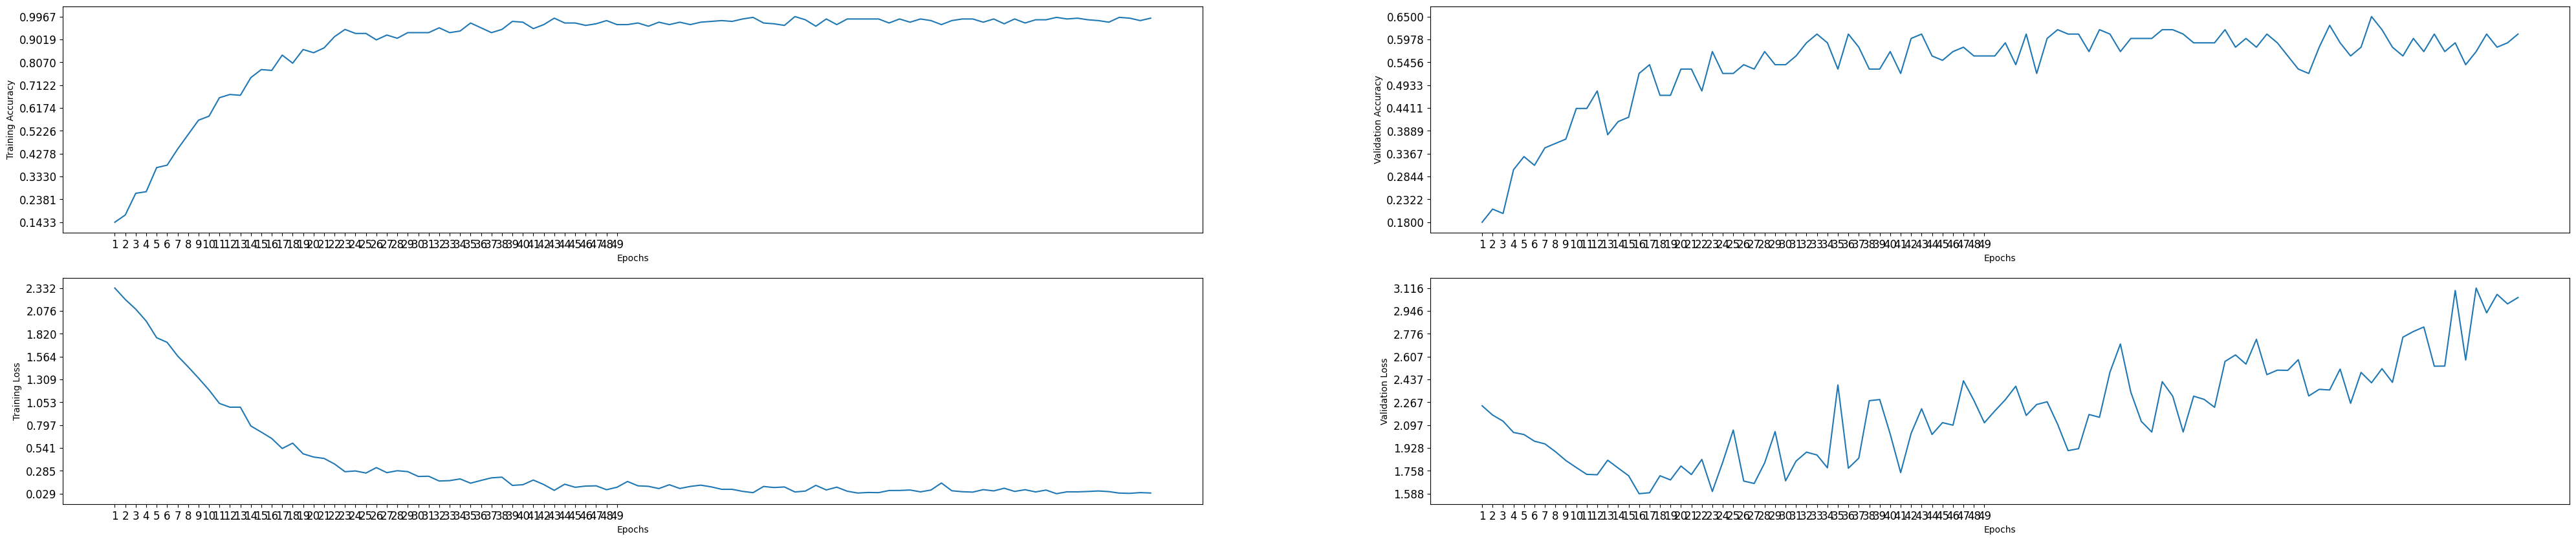

In [ ]:
fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (50, 10) )
train_x = range(1, len(history.history["accuracy"])+1)
train_y = history.history["accuracy"]
train_loss = history.history["loss"]
ax[0,0].plot(train_x, train_y)
ax[0,0].set_xlabel("Epochs")
ax[0,0].set_ylabel("Training Accuracy")
ax[0,0].set_xticks(range(1, 50))
ax[0,0].tick_params(axis = "both", labelsize = 12)
ax[0,0].set_yticks(np.linspace(start = min(train_y), stop = max(train_y), num = 10))

val_x = range(1, len(history.history["val_accuracy"])+1)
val_y = history.history["val_accuracy"]
ax[0,1].plot(val_x , val_y)
ax[0,1].set_xlabel("Epochs")
ax[0,1].set_ylabel("Validation Accuracy")
ax[0,1].set_xticks(range(1, 50))
ax[0,1].set_yticks(np.linspace(start = min(val_y), stop = max(val_y), num = 10))
ax[0,1].tick_params(axis = "both", labelsize = 12)

train_loss = history.history["loss"]
ax[1,0].plot(train_x, train_loss)
ax[1,0].set_xlabel("Epochs")
ax[1,0].set_ylabel("Training Loss")
ax[1,0].set_xticks(range(1, 50))
ax[1,0].tick_params(axis = "both", labelsize = 12)
ax[1,0].set_yticks(np.linspace(start = min(train_loss), stop = max(train_loss), num = 10))

val_loss = history.history["val_loss"]
ax[1,1].plot(train_x, val_loss)
ax[1,1].set_xlabel("Epochs")
ax[1,1].set_ylabel("Validation Loss")
ax[1,1].set_xticks(range(1, 50))
ax[1,1].tick_params(axis = "both", labelsize = 12)
ax[1,1].set_yticks(np.linspace(start = min(val_loss), stop = max(val_loss), num = 10))

plt.show()

## **Optonal Validation **- Validate the Train_ds_encoded shape and data for the first 2 frames in the first vedio.

In [ ]:
for video, label in train_ds_encoded.take(1):
    print("Video tensor data (first 2 frames):")
    # Slice the video tensor to include only the first 2 frames (index 0 and 1)
    print(video[:, :, :8, :, :, :])
    print("\nLabel tensor data:")
    print(label)

Video tensor data (first 2 frames):
tf.Tensor(
[[[[[[0.]
     [0.]
     [0.]
     ...
     [0.]
     [0.]
     [0.]]

    [[0.]
     [0.]
     [0.]
     ...
     [0.]
     [0.]
     [0.]]

    [[0.]
     [0.]
     [0.]
     ...
     [0.]
     [0.]
     [0.]]

    ...

    [[0.]
     [0.]
     [0.]
     ...
     [0.]
     [0.]
     [0.]]

    [[0.]
     [0.]
     [0.]
     ...
     [0.]
     [0.]
     [0.]]

    [[0.]
     [0.]
     [0.]
     ...
     [0.]
     [0.]
     [0.]]]


   [[[0.]
     [0.]
     [0.]
     ...
     [0.]
     [0.]
     [0.]]

    [[0.]
     [0.]
     [0.]
     ...
     [0.]
     [0.]
     [0.]]

    [[0.]
     [0.]
     [0.]
     ...
     [0.]
     [0.]
     [0.]]

    ...

    [[0.]
     [0.]
     [0.]
     ...
     [0.]
     [0.]
     [0.]]

    [[0.]
     [0.]
     [0.]
     ...
     [0.]
     [0.]
     [0.]]

    [[0.]
     [0.]
     [0.]
     ...
     [0.]
     [0.]
     [0.]]]


   [[[0.]
     [0.]
     [0.]
     ...
     [0.]
     [0.]
     [0.]]

    [[0.

In [ ]:
for frames, label in train_ds.take(1):
    print("Raw frames shape:", frames.shape)
    print("Label:", label.numpy())

for spikes, label in train_ds_encoded.take(2):
    # The shape after ISI phase encoding and batching is (batch_size, time_steps, frames, H, W, C)
    print("ISI phase encoded shape:", spikes.shape)
    print("Label one-hot shape:", label.shape)

    # Apply ISI phase encoding and one-hot encoding, then batch and prefetch the datasets
# The ISI_Phase_Encoder function outputs data in the shape (time_steps, frames, H, W, C)
# When batched, the shape becomes (batch_size, time_steps, frames, H, W, C)
# This is the correct input shape for the Conv3D layers, so no further flattening is needed.

Raw frames shape: (10, 10, 50, 50, 1)
Label: 0
ISI phase encoded shape: (8, 10, 10, 50, 50, 1)
Label one-hot shape: (8, 10)
ISI phase encoded shape: (8, 10, 10, 50, 50, 1)
Label one-hot shape: (8, 10)
